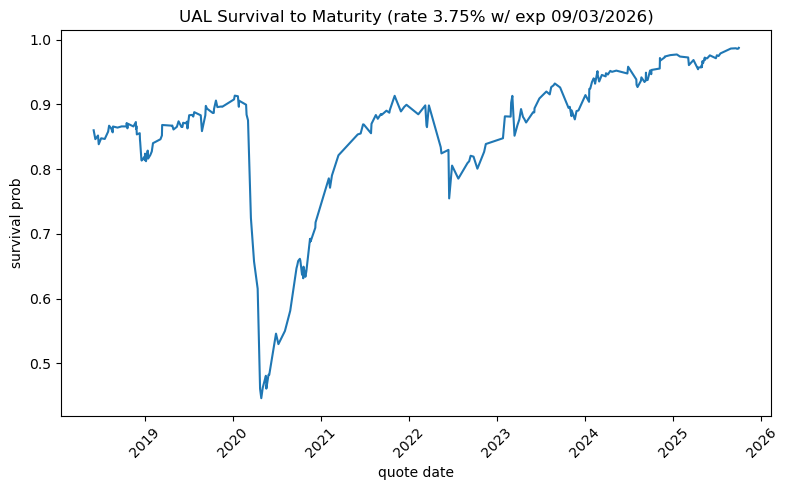


saved to /Users/anthonygiller/Downloads/UAL_reduced_form_survival.csv 

          date  last_value  spread_bps  spread_dec    hazard   tau_yrs  \
0   2018-06-04     109.617     109.617    0.010962  0.018270  8.254795   
1   2018-06-11     121.611     121.611    0.012161  0.020269  8.235616   
2   2018-06-22     117.185     117.185    0.011718  0.019531  8.205479   
3   2018-06-25     129.005     129.005    0.012900  0.021501  8.197260   
4   2018-07-05     121.420     121.420    0.012142  0.020237  8.169863   
5   2018-07-20     122.925     122.925    0.012292  0.020487  8.128767   
6   2018-08-03     113.665     113.665    0.011366  0.018944  8.090411   
7   2018-08-07     105.916     105.916    0.010592  0.017653  8.079452   
8   2018-08-16     110.066     110.066    0.011007  0.018344  8.054795   
9   2018-08-22     115.404     115.404    0.011540  0.019234  8.038356   
10  2018-08-23     107.574     107.574    0.010757  0.017929  8.035616   
11  2018-09-11     109.736     109.736 

In [17]:
#import libraries 

import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

#========================================

#loading csv 

file = "/Users/anthonygiller/Downloads/UAL_bond_price(Worksheet).csv"
raw = pd.read_csv(file)

#cleaning 

header = raw.iloc[0].tolist()
df = raw.iloc[2:].copy()
df.columns = header

#keeping date to last in spread 

df = df.rename(columns={"Date":"date","Last":"last_value"}).loc[:,["date","last_value"]]

#========================================

#parse dates + numeric 

def dates(x):
    
    for fmt in ("%m/%d/%Y","%m/%d/%y","%Y-%m-%d"):
        
        try: return datetime.strptime(str(x), fmt).date()
        except: pass
    return pd.NaT


def tnum(x):
    
    s = str(x).replace(",", "").strip()
    
    try: return float(s)
    except: return np.nan
    

df["date"] = df["date"].apply(dates)
df["last_value"] = df["last_value"].apply(tnum)
df = df.dropna(subset=["date", "last_value"]).sort_values("date").reset_index(drop=True)

#========================================

#reduced form - spread, hzrd, survival probs 


df["spread_bps"] = df["last_value"]          
df["spread_dec"] = df["spread_bps"] / 1e4


#assuming recovery rate 

r = 0.4                                      
df["hazard"] = df["spread_dec"] / (1 - r)


#taking exp maturity from bond des

expm = datetime(2026, 9, 3).date()

df["tau_yrs"] = (pd.to_datetime(expm) - pd.to_datetime(df["date"])).dt.days / 365.0
df = df[df["tau_yrs"] >= 0].copy()


#calculating survival under constant hzrd to maturity 

df["s_tau"] = np.exp(-df["hazard"] * df["tau_yrs"])

#save as csv 

saved = "/Users/anthonygiller/Downloads/UAL_reduced_form_survival.csv"
df.to_csv(saved, index=False)

#========================================

#plot survival prob 

plt.figure(figsize=(8,5))

plt.plot(df["date"], df["s_tau"])
plt.title("UAL Survival to Maturity (rate 3.75% w/ exp 09/03/2026)")
plt.xlabel("quote date") 
plt.ylabel("survival prob")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

#saved msg with file path and showing first 12 rows 

print(f"\nsaved to {saved} \n")
print(df.head(12))
